<a href="https://colab.research.google.com/github/lbrong622/practice/blob/master/Project_DeepHedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import numpy as np
import tensorflow as tf
import numpy.random as npr
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add, Dot
from tensorflow.keras.backend import constant
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
import scipy.stats as st
import math
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
plt.style.use('ggplot')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')


Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


# Define functions and generate data

In [ ]:
S = 1
U = 2
T = 0.5
r0 = 0.02
a = 0.5
b = 0.05
sigma = 0.05
mu = b + sigma/a
ntrain= 500000
ntest  = 300000
nSteps = 100

In [ ]:
def simulateVasicek(a, mu, sigma, T, r0, nPaths, nSteps):
    dt = T/nSteps
    times = np.arange(0,T+dt,dt)
    curr_r= r0
    r = np.zeros((nPaths, nSteps))
    first = math.exp(-a*dt)
    for i in range(nSteps):
        dW = npr.normal(0,1,(nPaths,))
        curr_r = curr_r*first + mu*(1-first) + sigma * math.sqrt((1-first**2)/(2*a))*dW
        r[:,i] = curr_r
    r = np.reshape(r,(nPaths,nSteps))
    return r,times

def affinebondprcing(a,b, sigma,t, s, r_t):
    B = (1-math.exp(-a*(s-t)))/a
    A = math.exp((b - 0.5*(sigma/a)**2)*(B-s+t) - 0.25*B**2 * sigma**2/a)
    price =  A* np.exp(-B*r_t)
    dur = np.multiply(-B, price)
    con = np.multiply(pow(B,2), price)
    return price, dur, con
#price the dt-maturity zero coupon bond, which can be regarded as a money market discounting rate
def ShortMaturityPricing(r_t):
    a = 0.5
    b = 0.05
    sigma = 0.05
    dt = 0.5/100
    B = (1-math.exp(-a*(dt)))/a
    A = math.exp((b - 0.5*(sigma/a)**2)*(B-dt) - 0.25*B**2 * sigma**2/a)
    rate =  A* np.exp(-B*r_t)
    return rate
    
def accrue_moneymarket_discount(moneymarket):
    accrue  = 1
    for i in range(nSteps):
        accrue = np.multiply(accrue, moneymarket[:,i])
  
    return accrue 

In [ ]:
def HedgeWithS_Ubond( r_paths, nPaths, nSteps, charge, tx_costs,epsilon):
  T = 0.5
  U = 2
  S = 1
  r0 = 0.02
  a = 0.5
  b = 0.05
  sigma = 0.05
  lamada = -1
  mu = b - lamada*sigma/a
  dt = T/nSteps
  tim = np.arange(0,T+dt,dt)
  strategy_S = np.zeros((nPaths, nSteps))
  strategy_U = np.zeros((nPaths, nSteps))
  cost = np.zeros((nPaths, nSteps+1))
  #simulate interest paths in P measure
  #inital status: the trader issue a T-bond and hold Q_0 positions of S-bond
  # the rest of her weath will be invested in short maturity ZCBs
  price_T, Dur_T, Con_T = affinebondprcing(a,b, sigma,0, T, r0)
  price_S, Dur_S, Con_S = affinebondprcing(a,b, sigma,0, S, r0)
  price_U, Dur_U, Con_U = affinebondprcing(a,b, sigma,0, U, r0)
  InitialWeath = charge
  Quantity_S = (Con_U*Dur_T - Dur_U*Con_T)/(Dur_S*Con_U - Dur_U*Con_S)
  Quantity_U = (Con_T*Dur_S - Dur_T*Con_S)/(Dur_S*Con_U - Dur_U*Con_S)
  amount_to_buy = Quantity_S * price_S + Quantity_U * price_U
  moneyAccount = InitialWeath -amount_to_buy
  if tx_costs == True:
    transaction_costs = epsilon* (abs(Quantity_S) * price_S + abs(Quantity_U) * price_U)
    moneyAccount = moneyAccount -transaction_costs
    cost[:,0] = transaction_costs

  q_moneyaccount= moneyAccount / ShortMaturityPricing(r0)
  strategy_S[:,0] = Quantity_S
  strategy_U[:,0] = Quantity_U
  

  for i in range(nSteps-1):
      _, Dur_T,Con_T = affinebondprcing(a,b, sigma, tim[i+1], T, r_paths[:,i+1])
      price_S, Dur_S, Con_S = affinebondprcing(a,b, sigma,tim[i+1] , S, r_paths[:,i+1])
      price_U, Dur_U, Con_U = affinebondprcing(a,b, sigma,tim[i+1] , U, r_paths[:,i+1])
    #liqudation of the previous step
      moneyAccount = 1* q_moneyaccount
       
    #duration and convexity  neutral

      newQuantity_S = np.divide((np.multiply(Con_U,Dur_T) - np.multiply(Dur_U,Con_T)), (np.multiply(Dur_S,Con_U) - np.multiply(Dur_U, Con_S)))
      newQuantity_U = np.divide((np.multiply(Con_T,Dur_S ) - np.multiply(Dur_T,Con_S)), (np.multiply(Dur_S,Con_U) - np.multiply(Dur_U, Con_S)))

      rebalance =  np.multiply( newQuantity_S, price_S) + np.multiply(newQuantity_U, price_U)  - np.multiply(Quantity_S , price_S) - np.multiply(Quantity_U , price_U)

      moneyAccount = moneyAccount - rebalance

      if tx_costs == True:
        absChange = np.abs(np.multiply( newQuantity_S, price_S)  - np.multiply(Quantity_S , price_S)) + np.abs(np.multiply(newQuantity_U, price_U) - np.multiply(Quantity_U , price_U))
        transaction_costs = epsilon* absChange
        moneyAccount = moneyAccount -  transaction_costs
        cost[:,i+1] = transaction_costs
    # holding postions for the next step
      q_moneyaccount = np.divide(moneyAccount , ShortMaturityPricing(r_paths[:,i+1]))
      strategy_S[:,i+1] = newQuantity_S 
      strategy_U[:,i+1] = newQuantity_U 
      Quantity_S = newQuantity_S
      Quantity_U = newQuantity_U


      #final step the trader will pay the payoff of T-bond and sell all her
      #holding positons
  liability = 1 # 1 unit T-bond
  Price_S,_,_= affinebondprcing(a,b, sigma,T, S, r_paths[:,nSteps])
  Price_U,_,_= affinebondprcing(a,b, sigma,T, U, r_paths[:,nSteps])
  liquidation = q_moneyaccount*1 + np.multiply(Quantity_S, Price_S)+ np.multiply(Quantity_U, Price_U)
  PnL = liquidation  - liability
  if tx_costs == True:
    transaction_costs = epsilon* (np.abs(np.multiply(Quantity_S, Price_S)) + np.abs(np.multiply(Quantity_U, Price_U)))
    cost[:,-1] = transaction_costs
    PnL = PnL - transaction_costs 
        # this the VaR for  the of the whole hedging horizon 
  return PnL,strategy_S,strategy_U,cost
    


In [ ]:
#####Simple Feedforward neural network without transaction cost
def FeedSU_bond_FNN(trans_costs = None, charge = None, selling = None, epsilon = None):
  initializers = tf.keras.initializers.RandomNormal(mean = 0, stddev=0.1)
  layer1 = keras.layers.Dense(10,activation = 'relu', kernel_initializer= initializers)
  layer2 = keras.layers.Dense(10,activation = 'relu', kernel_initializer=initializers)
  bn1 = keras.layers.BatchNormalization(momentum=0.99)
  bn2 = keras.layers.BatchNormalization(momentum=0.99)
  bn3 = keras.layers.BatchNormalization(momentum=0.99)

  N = nSteps+1
  dt = T/nSteps
  time = np.arange(0,dt+T,dt)
  inputs =  []
  inputs1 = []
  inputs2 = []
  if selling == True:
    initial_charge = charge
    payment = 1
  else:
    initial_charge = 0
    payment = 0
 
  for j in range(N):
        
        if j < N-1:
            
                
                price = Input(shape = (2,))
                moneymarket_price = Input(shape = (1,))
                x = layer1(price)
                x = bn1(x)       
                x = layer2(x)
                x = bn2(x)
                strategy = keras.layers.Dense(2,activation='elu',name = 'strategy' + str(j))(x)

                if j == 0:
                    
                        holding_strategy = tf.zeros_like(strategy)
            
                
                    
                rebalance = Subtract()([strategy, holding_strategy])
                holding_strategy = strategy
                rebalance_cashflow = Multiply()([rebalance,price])
                

                if trans_costs == True:
                    
                        absolutechanges = Lambda(lambda x : K.abs(x))(rebalance_cashflow)
                        transaction_costs = Lambda(lambda x : epsilon*x, name = 'transanction_costs'+ str(j))(absolutechanges)
                        transaction_costs  = K.sum(transaction_costs , axis = -1)
                        

                rebalance_cashflow = K.sum(rebalance_cashflow, axis = -1) 

                if j == 0:
                    
                        wealth = Lambda(lambda x : initial_charge - x)(rebalance_cashflow)
                else:
                    
                        wealth = Subtract()([wealth, rebalance_cashflow])
                if trans_costs == True:       
                        wealth = Subtract()([wealth, transaction_costs])
                        
                wealth = Multiply(name = 'moneymarket'+ str(j))([wealth, 1/moneymarket_price])#invest the rest of her wealth in money market
                inputs1.append(price)
                inputs2.append(moneymarket_price)
                
                
        else:
            #final step
                price = Input(shape = (2,))
                moneymarket_price  = Input(shape = (1,))
                liquadation = Multiply()([holding_strategy,price])
                
                if trans_costs == True:
                    
                        absolutechanges = Lambda(lambda x : K.abs(x))(liquadation)
                        transaction_costs = Lambda(lambda x : epsilon * x, name = 'transanction_costs'+ str(j))(absolutechanges)  
                        liquadation = Subtract()([liquadation, transaction_costs])


                liquadation = K.sum(liquadation, axis = -1)        
                wealth = Add()([wealth,liquadation])
                wealth = Lambda(lambda x: x - payment)(wealth)
                inputs1.append(price)
                inputs2.append(moneymarket_price)
                

  
               
  inputs = inputs1 + inputs2      
 
  model = keras.models.Model(inputs = inputs , outputs = wealth)
  return model

Generate data for training and test

In [ ]:
rtrain,times = simulateVasicek(a, mu, sigma , T, r0, ntrain, nSteps)
r_0 = [r0]
r_0 = np.repeat(r_0,ntrain,axis =0)
r_train = np.concatenate((np.reshape(r_0,(ntrain,1)),rtrain),axis = 1)
print(np.shape(r_train))



(500000, 101)


In [ ]:
rtest,times = simulateVasicek(a, mu, sigma , T, r0, ntest, nSteps)
r_0 = [r0]
r_0 = np.repeat(r_0,ntest,axis =0)
r_test = np.concatenate((np.reshape(r_0,(ntest,1)),rtest),axis = 1)

print(np.shape(r_test))

(300000, 101)


In [ ]:
# Generate the training and testing data set
price_S = np.zeros((ntrain,nSteps+1))
price_U = np.zeros((ntrain,nSteps+1))
prc_S_test = np.zeros((ntest,nSteps+1))
prc_U_test = np.zeros((ntest,nSteps+1))
moneymarket = np.zeros((ntrain,nSteps+1))
moneymarket_test = np.zeros((ntest,nSteps+1))
for i in range(nSteps+1):
    price_U[:,i],_ , _   = affinebondprcing(a,b, sigma, times[i] , U , r_train[:,i])
    price_S[:,i],_ , _   = affinebondprcing(a,b, sigma, times[i] , S , r_train[:,i])
    prc_U_test[:,i],_ , _ = affinebondprcing(a,b, sigma, times[i] , U , r_test[:,i])
    prc_S_test[:,i],_ , _ = affinebondprcing(a,b, sigma, times[i] , S , r_test[:,i])
    moneymarket[:,i] = ShortMaturityPricing(r_train[:,i])
    moneymarket_test[:,i] = ShortMaturityPricing(r_test[:,i])

In [ ]:
FeedSUtrain = []
for i in range(nSteps+1):
  S_helper = np.reshape(price_S[:,i],(ntrain,1))
  U_helper = np.reshape(price_U[:,i],(ntrain,1))
  FeedSUtrain.append(np.concatenate((S_helper,U_helper),axis =1))
for i in range(nSteps+1):
  moneymarket_helper = np.reshape(moneymarket[:,i],(ntrain,1)) 
  FeedSUtrain.append(moneymarket_helper)

print(np.shape(FeedSUtrain[1]))

FeedSUtest = []
for i in range(nSteps+1):
  S_helper = np.reshape(prc_S_test[:,i],(ntest,1))
  U_helper = np.reshape(prc_U_test[:,i],(ntest,1))
  FeedSUtest.append(np.concatenate((S_helper, U_helper),axis =1))
for i in range(nSteps+1):
  moneymarket_helper = np.reshape(moneymarket_test[:,i],(ntest,1)) 
  FeedSUtest.append(moneymarket_helper)
 
print(np.shape(FeedSUtest[1]))

(500000, 2)
(300000, 2)


In [ ]:
###inital charge of the T-bond, which is the risk neutral price
charge ,_ ,_ =  affinebondprcing(a,b, sigma,0 , T, r0)
print(charge)
moneymarket_discount_test = accrue_moneymarket_discount(moneymarket_test)
moneymarket_discount_train = accrue_moneymarket_discount(moneymarket)

0.9883833161922158


Test the data we generated

0.020035258770254104


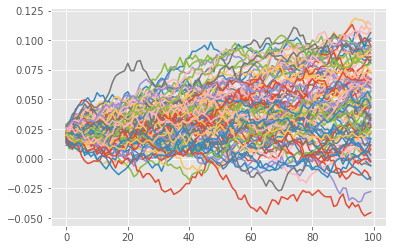

0.9743611904608563 0.9783390719043343 0.9700472383854137
(500000, 101)
0.0


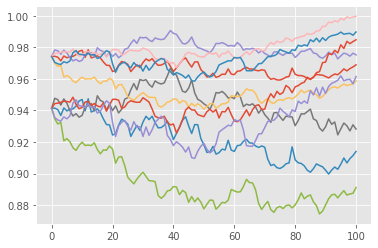

In [ ]:
for i in range(100):
  plt.plot(rtrain[i,:])

for i in range(5):
  plt.plot(price_S[i,:])
  plt.plot(price_U[i,:])


# Ture label, the hedging error(PnL)

(500000,)
(500000,)


(array([2.0000e+00, 1.0000e+00, 4.0000e+00, 6.0000e+00, 2.7000e+01,
        6.5000e+01, 1.3400e+02, 3.0900e+02, 6.4500e+02, 1.2760e+03,
        2.2760e+03, 4.0700e+03, 6.7690e+03, 1.0517e+04, 1.5479e+04,
        2.2024e+04, 2.9360e+04, 3.6455e+04, 4.2587e+04, 4.7548e+04,
        4.9370e+04, 4.7883e+04, 4.3944e+04, 3.8564e+04, 3.1088e+04,
        2.4211e+04, 1.7217e+04, 1.1669e+04, 7.4030e+03, 4.3240e+03,
        2.4390e+03, 1.2480e+03, 5.8300e+02, 2.9400e+02, 1.3000e+02,
        4.8000e+01, 1.9000e+01, 1.0000e+01, 1.0000e+00, 1.0000e+00]),
 array([-1.05307529, -1.05078049, -1.04848569, -1.0461909 , -1.0438961 ,
        -1.0416013 , -1.03930651, -1.03701171, -1.03471691, -1.03242212,
        -1.03012732, -1.02783252, -1.02553773, -1.02324293, -1.02094813,
        -1.01865334, -1.01635854, -1.01406374, -1.01176895, -1.00947415,
        -1.00717935, -1.00488455, -1.00258976, -1.00029496, -0.99800016,
        -0.99570537, -0.99341057, -0.99111577, -0.98882098, -0.98652618,
        -0.98423

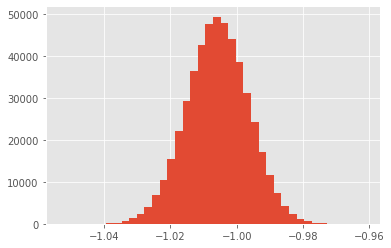

In [ ]:
#if charge risk neutral or not sell
ytrain = np.zeros((ntrain))
print(np.shape(ytrain))
#if don't charge
ytrain_nocharge = -1*charge/moneymarket_discount_train
print(np.shape(ytrain))
plt.hist(ytrain_nocharge, bins = 40)


# Convex Risk measure

In [ ]:
def CVaR_95(y_true, y_pred):
  alpha = 0.95
  loss = -(y_pred - y_true)
  VaR = tfp.stats.percentile(loss,alpha*100)
  tail = loss[loss>=VaR]
  CVaR = K.mean(tail)
  return CVaR

def CVaR_05(y_true, y_pred):
  alpha = 0.5
  loss = -(y_pred - y_true)
  VaR = tfp.stats.percentile(loss,alpha*100)
  tail = loss[loss>=VaR]
  CVaR = K.mean(tail)
  return CVaR


def CVaR_99(y_true, y_pred):
  alpha = 0.99
  loss = -(y_pred - y_true)
  VaR = tfp.stats.percentile(loss,alpha*100)
  tail = loss[loss>=VaR]
  CVaR = K.mean(tail)
  return CVaR

def entropic_1(y_true, y_pred):
  Lambda = 1
  ret = K.mean(K.exp(-Lambda*(y_pred - y_true)))
  return ret 


In [ ]:

def VaR(x, a):
  loss = -x
  VaR = np.quantile(loss,a)
  return VaR

def ES(x, a):
  loss = -x
  VaR = np.quantile(loss,a)
  tail = loss[loss >= VaR]
  ret = np.mean(tail)
  return ret


In [ ]:
def entropic_riskmeasure(x,Lambda):
      ret = (1/Lambda)*np.log(np.mean(np.exp(-Lambda*x)))
      return ret

def indifferenceprice_q_Z(Z,Lambda):
  
  q_Z = np.mean(entropic_riskmeasure(Z,Lambda)*moneymarket_discount_test)
  return q_Z
  
def exponential_utility(x,Lambda):
  ret = -np.mean(np.exp(-Lambda*x))
  return ret

In [ ]:

def scheduler2(epoch, lr):
  if epoch % 5 == 0 and epoch != 0:
        lr = lr * math.exp(-0.5)
  return lr
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)


In [ ]:
optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

optimizer4 = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

batch_size = 250

# S and U bonds

In [ ]:
FeedSU_FNN95 = FeedSU_bond_FNN(trans_costs= False, charge= 0,selling = True,epsilon= 0.0)
FeedSU_FNN99 = FeedSU_bond_FNN(trans_costs= False, charge= 0,selling = True, epsilon= 0.0)
FeedSU_FNN99_costs = FeedSU_bond_FNN(trans_costs= True, charge= 0,selling = True, epsilon= 0.001)
FeedSU_FNN95_costs = FeedSU_bond_FNN(trans_costs= True, charge= 0,selling = True,epsilon= 0.001)

# train

In [ ]:
FeedSU_FNN95.compile(optimizer  =tf.keras.optimizers.Adam(learning_rate=0.005),loss = CVaR_95)
FeedSU_FNN99.compile(optimizer  =tf.keras.optimizers.Adam(learning_rate=0.005),loss = CVaR_99)
FeedSU_FNN99_costs.compile(optimizer  =  tf.keras.optimizers.Adam(learning_rate=0.005),loss = CVaR_99)
FeedSU_FNN95_costs.compile(optimizer  = tf.keras.optimizers.Adam(learning_rate=0.005),loss = CVaR_95) 

In [ ]:
tf.keras.backend.set_learning_phase(1)
history1 =  FeedSU_FNN99.fit(FeedSUtrain, ytrain_nocharge, batch_size=250, epochs =  20, callbacks=callback2, validation_split = 0.3)

In [ ]:
tf.keras.backend.set_learning_phase(1)
history2 =  FeedSU_FNN95.fit(FeedSUtrain, ytrain_nocharge, batch_size=250, epochs = 20, callbacks = callback2, validation_split = 0.3)

In [ ]:
tf.keras.backend.set_learning_phase(1)
history3 =  FeedSU_FNN95_costs.fit(FeedSUtrain, ytrain_nocharge, batch_size=250, epochs = 20, callbacks = callback2, validation_split = 0.3)

In [ ]:
tf.keras.backend.set_learning_phase(1)
history4 =  FeedSU_FNN99_costs.fit(FeedSUtrain, ytrain_nocharge, batch_size=250, epochs = 20, callbacks = callback2, validation_split = 0.3)

In [ ]:
tf.keras.backend.set_learning_phase(0)
PnL_SU95nocharge = np.reshape(FeedSU_FNN95.predict(FeedSUtest),(ntest,))
PnL_SU99nocharge  = np.reshape(FeedSU_FNN99.predict(FeedSUtest),(ntest,))
PnL_SU99_costnocharge  = np.reshape(FeedSU_FNN99_costs.predict(FeedSUtest),(ntest,))
PnL_SU95_costnocharge  = np.reshape(FeedSU_FNN95_costs.predict(FeedSUtest),(ntest,))

In [ ]:
PnL_SU95 = PnL_SU95nocharge + charge/moneymarket_discount_test
PnL_SU99 = PnL_SU99nocharge + charge/moneymarket_discount_test
PnL_SU95_cost= PnL_SU95_costnocharge + charge/moneymarket_discount_test
PnL_SU99_cost = PnL_SU99_costnocharge + charge/moneymarket_discount_test

In [ ]:
PnL_gamma,_, _ ,_= HedgeWithS_Ubond(r_test, ntest, nSteps, charge = charge, tx_costs=False, epsilon = 0.0)
PnL_gamma_cost,strategy_S, strategy_U, SU_costs = HedgeWithS_Ubond(r_test, ntest, nSteps, charge = charge, tx_costs=True, epsilon = 0.001)

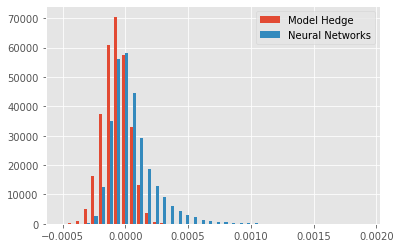

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

.99gamma 0.000341032740519047
.99NN 0.00024302890257148387
.95gamma 0.0002790478572583805
.95NN 0.0001923547368480895
gammamean -6.866717083183687e-05
NNmean 4.896273998429501e-05
gamma relative error 0.00012423923393535812
NN relative error 0.00018347232944467855


In [ ]:
PnL_99_nocost = plt.figure()
plt.hist([PnL_gamma, PnL_SU99],bins = 40, label = ['Model Hedge', 'Neural Networks'])
plt.legend()
plt.show()
PnL_99_nocost.savefig("PnL_99_nocost.png")
#files.download("PnL_99_nocost.png")
print('.99gamma',ES(PnL_gamma,.99))
print('.99NN',ES(PnL_SU99,.99))
print('.95gamma',ES(PnL_gamma,.95))
print('.95NN',ES(PnL_SU99,.95))
print('gammamean',np.mean(PnL_gamma))
print('NNmean',np.mean(PnL_SU99))
print('gamma relative error',np.sqrt(np.mean(np.power(PnL_gamma,2)))/charge)
print('NN relative error',np.sqrt(np.mean(np.power(PnL_SU99,2)))/charge)

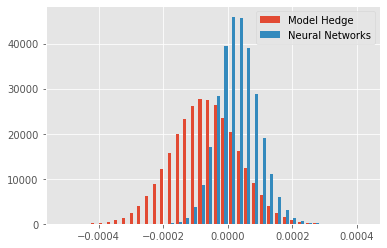

0.0004284040662323463
0.0004031619379427642
.99gamma 0.000341032740519047
.99NN 0.000125328894932089
.95gamma 0.0002790478572583805
.95NN 9.141428571534495e-05
mean -6.866717083183687e-05
mean 2.9948798894982762e-05
-0.009089460415747094
0.2281206819770534
gamma relative error 0.00012423923393535812
NN relative error 6.943077215648788e-05


In [ ]:
PnL_95_nocost = plt.figure()
plt.hist([PnL_gamma, PnL_SU95],bins = 40, label = ['Model Hedge', 'Neural Networks'])
plt.legend()
plt.show()
print(max(PnL_SU95))
print(max(PnL_gamma))
PnL_95_nocost.savefig("PnL_95_nocost.png")
#files.download("PnL_95_nocost.png")
print('.99gamma',ES(PnL_gamma,.99))
print('.99NN',ES(PnL_SU95,.99))
print('.95gamma',ES(PnL_gamma,.95))
print('.95NN',ES(PnL_SU95,.95))
print('mean',np.mean(PnL_gamma))
print('mean',np.mean(PnL_SU95))
print(st.skew(PnL_gamma))
print(st.skew(PnL_SU95))
print('gamma relative error',np.sqrt(np.mean(np.power(PnL_gamma,2)))/charge)
print('NN relative error',np.sqrt(np.mean(np.power(PnL_SU95,2)))/charge)

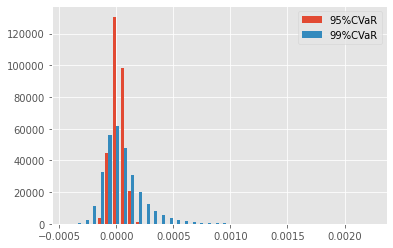

In [ ]:
PnL_95vs99_nocost = plt.figure()
plt.hist([PnL_SU95 , PnL_SU99],bins = 40, label = ['95%CVaR', '99%CVaR'])
plt.legend()
plt.show()
PnL_95vs99_nocost.savefig('PnL_95vs99_nocost.png')

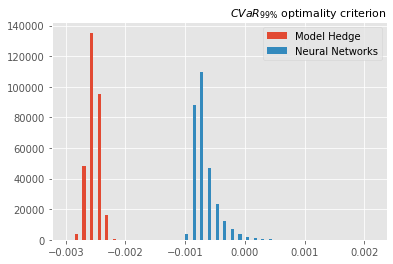

-0.000699190555480652
-0.0025091862853249924
Model Hedge 0.002780537520144761
NN Hedge 0.0009680155146078741


In [ ]:
PnL_99cost = plt.figure()
PnL_99_cost = plt.hist([PnL_gamma_cost, PnL_SU99_cost,],bins = 40, label = ['Model Hedge', 'Neural Networks'])
plt.title('$CVaR_{99\%}$ optimality criterion' , loc='right', fontsize=11)
plt.legend()
plt.show()
print(np.mean(PnL_SU99_cost))
print(np.mean(PnL_gamma_cost))
print('Model Hedge',ES(PnL_gamma_cost,.99))
print('NN Hedge',ES(PnL_SU99_cost,.99))
PnL_99cost.savefig('PnL_99cost.png')
#files.download('PnL_99cost.png')

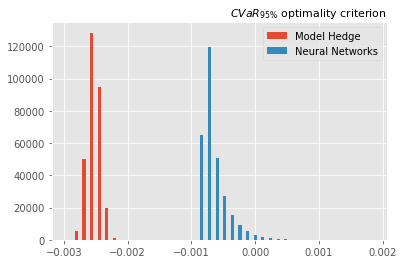

-0.0006591197656789412
-0.002509629901153782
Model Hedge 0.002719370289116316
NN Hedge 0.000865354905534021


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
PnL_95cost = plt.figure()
PnL_95_cost = plt.hist([PnL_gamma_cost, PnL_SU95_cost,],bins = 40, label = ['Model Hedge', 'Neural Networks'])
plt.title('$CVaR_{95\%}$ optimality criterion' , loc='right', fontsize=11)
plt.legend()
plt.show()
print(np.mean(PnL_SU95_cost))
print(np.mean(PnL_gamma_cost))
print('Model Hedge',ES(PnL_gamma_cost,.95))
print('NN Hedge',ES(PnL_SU95_cost,.95))
PnL_95cost.savefig('PnL_95cost.png')
#files.download('PnL_95cost.png')

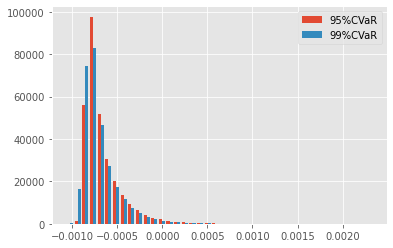

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test2 = plt.figure()
PnL_95vs99_cost = plt.hist([PnL_SU95_cost , PnL_SU99_cost],bins = 40, label = ['95%CVaR', '99%CVaR'])
plt.legend()
plt.show()
test2.savefig("PnL_95vs99_cost.png")
files.download("PnL_95vs99_cost.png")

In [ ]:
def get_SU_NN_cost_realized(ntest, test_set, test_model):
    totalcost_realized = np.zeros((ntest,nSteps+1))
    for i in range(nSteps+1):
        tf.keras.backend.set_learning_phase(0)
        get_trans_costs = keras.Model(inputs=test_model.input, outputs= test_model.get_layer(name = 'transanction_costs'+ str(i)).output)
        cost_realized = get_trans_costs.predict(test_set)
        cost_realized = np.sum(cost_realized, axis = -1)#add the costs of S and U bond together
        totalcost_realized[:,i] = cost_realized
    return totalcost_realized

In [ ]:
#run-time 3018 seconds, because we put the trading part(buy S, U and moneymarket) into the nerual network construction 
#for the convenience of outputting PnL
#but this make the retriving of realized strategies and realized costs very slow
#we can also put the trading part into the cost function, which means the coss function will be more complicated
totalcost_NN95 = get_SU_NN_cost_realized(ntest,FeedSUtest, FeedSU_FNN95_costs)
print(np.shape(SU_costs),np.shape(totalcost_NN95))

In [ ]:
NNtotalcost_NN95 = np.sum(totalcost_NN95,axis = -1)
SU_model_totalcosts = np.sum(SU_costs,axis=-1)
print(np.mean(NNtotalcost_NN95))
print(np.mean(SU_model_totalcosts ))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

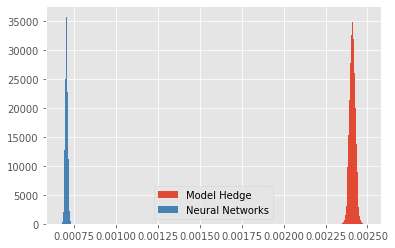

In [ ]:
costcompare = plt.figure()
plt.hist(SU_model_totalcosts  ,bins = 30, label = 'Model Hedge') 
plt.hist(NNtotalcost_NN95,color='steelblue' ,bins = 30,label = 'Neural Networks')
plt.legend()
costcompare.savefig("costcompare.png")
files.download("costcompare.png")

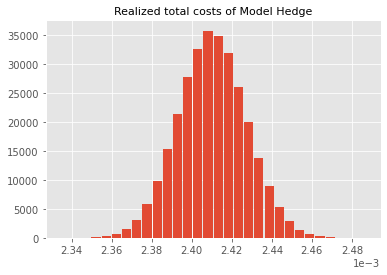

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

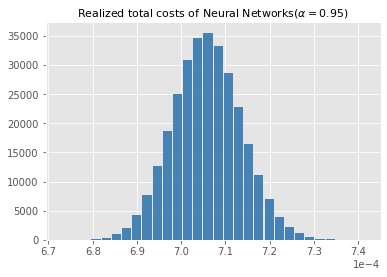

In [ ]:
modelcosts = plt.figure()
plt.hist(SU_model_totalcosts,bins = 30,rwidth=0.9)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(r'Realized total costs of Model Hedge', size = 11)
plt.show()
modelcosts.savefig('modelcost.png')
NNcost = plt.figure()
plt.hist(NNtotalcost_NN95 ,bins = 30, rwidth=0.9,color='steelblue') 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title(r'Realized total costs of Neural Networks($\alpha = 0.95$)', size = 11)
NNcost.savefig('NNcost.png')
files.download('NNcost.png')

#price asymtotics

In [ ]:
eps = np.zeros((5))
for i in range(5):
  eps[i] = 2**(-(i+6))
print(eps)
print(len(eps))

[0.015625   0.0078125  0.00390625 0.00195312 0.00097656]
5


In [ ]:
#compute pi(-Z)
History_riskadjusted= []
riskadjusted =  []
for i in range(len(eps)):
    SU_95 =  FeedSU_bond_FNN(trans_costs= True, charge= 0,selling = True, epsilon= eps[i])
    SU_95.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate=0.005),loss = CVaR_95)
    history = SU_95.fit(FeedSUtrain, ytrain_nocharge, batch_size=250, epochs = 20, callbacks = callback2, validation_split = 0.3)
    History_riskadjusted.append(history)
    riskadjusted.append(SU_95)

$p(-Z) = E[D(0,T)]\pi(-Z) = E[D(0,T)][\pi(-Z) -\pi(0)]\geq E[D(0,T)]\pi(-Z)$

In [ ]:

def computePnL_eps(eps):
  PnL_95eps =[]
  for i in range(len(eps)):
    PnL_95eps.append(np.reshape(riskadjusted[i].predict(FeedSUtest),(ntest,)))
  return PnL_95eps

def compute_pi_Z(eps, PnL_95eps):
  pi_Z_95 =[]
  for i in range(len(eps)):
      pi_Z_95.append(np.mean(ES(PnL_95eps[i],.95)*moneymarket_discount_test))
  return pi_Z_95
def indifferenceprice_asymptotics(PnL_95eps,eps):
  log_p_q = []
  indifferenceprice = []
  for i in range(len(eps)):
    indifferenceprice.append(indifferenceprice_q_Z(PnL_95eps[i],1))
  
  for i in range(len(eps)):
     log_p_q .append(np.log(indifferenceprice[i]- charge))

  log_eps = np.log(np.array(eps))
  log_p_q  = np.array( log_p_q )
  indifference_asymptotic = plt.figure()
  coef_2 = np.polyfit(log_eps, log_p_q ,1)
  poly1d_fn_2 = np.poly1d(coef_2) 
  plt.plot(log_eps, log_p_q , 'o', log_eps, poly1d_fn_2(log_eps),'--')
  plt.xlabel('$log(\epsilon)$') 
  plt.ylabel('$log(p_\epsilon - p_0)$') 
  indifference_asymptotic.savefig('indifference_asymptotic_95.png')
  #files.download('indifference_asymptotic_95.png')
  print('regression coef' coef_2)
  return indifferenceprice



entropic risk measure
$\rho(X) = \frac{1}{\lambda}\log(\mathbb{E}[\exp(-\lambda X)])$

untility indifference price

$p_\epsilon \\
= \mathbb{E}[D(t)] (\pi(-Z) - \pi(0))\\
=\mathbb{E}[D(t)](\rho(-Z + (\delta\cdot S)_T - C_T(\delta))- \rho(0))\\
= \mathbb{E}[D(t)](\rho(-Z + (\delta\cdot S)_T - C_T(\delta)))$


In [ ]:
tf.keras.backend.set_learning_phase(0)
PnL_95eps = computePnL_eps(eps)

 discounted pi(-1) [1.0126695807897839, 1.0116170545083574, 1.009373641133131, 1.0081908377785802, 1.0075620634517304]
regression coef [ 0.86367321 -1.16578759]
utility indifference price [0.9963370299919893, 0.9935042065853895, 0.9910665491568901, 0.9897958790713653, 0.989142384904202]


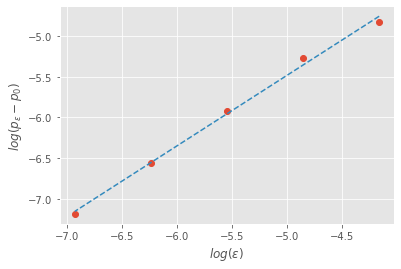

In [ ]:
#pi(-Z)
pi_Z_95 = compute_pi_Z(eps, PnL_95eps)
print(' discounted pi(-1)',pi_Z_95)
Pi_95 = ES(PnL_SU95nocharge, 0.95)
#exponential utility indifference price
indifferenceprice = indifferenceprice_asymptotics(PnL_95eps,eps)
print('utility indifference price',indifferenceprice)


In [ ]:
p_adjusted_95_nocosts  =  np.mean(ES(PnL_SU95nocharge, 0.95)*moneymarket_discount_test)
print('riskadjustednocosts',p_adjusted_95_nocosts )
indifferenceprice_nocost =  indifferenceprice_q_Z(PnL_SU95nocharge,1)
print(indifferenceprice_nocost)

[0.97408356 0.76259896]


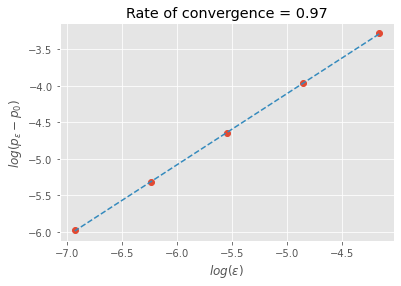

In [ ]:

def model_asympototics(eps):
  gamma_p_eps = []
  charge,_,_ = affinebondprcing(0.5,0.05,0.05,0,0.5,0.02)
  for i in range(len(eps)):
      PnL_nocharge,_,_,_ = HedgeWithS_Ubond(r_test, ntest, nSteps, charge = 0, tx_costs=True, epsilon = eps[i])
      p = indifferenceprice_q_Z(PnL_nocharge, 1) -charge
      gamma_p_eps.append(p)
  log_gamma_p_eps = np.log(np.array(gamma_p_eps))
  log_eps = np.log(np.array(eps))
  indifference_asymptotic_vasicek = plt.figure()
  coef_1 = np.polyfit(log_eps,log_gamma_p_eps ,1)
  poly1d_fn_1 = np.poly1d(coef_1) 
  plt.plot(log_eps,log_gamma_p_eps , 'o', log_eps, poly1d_fn_1(log_eps),'--')
  plt.xlabel('$log(\epsilon)$') 
  plt.ylabel('$log(p_\epsilon - p_0)$') 
  plt.title('Rate of convergence = 0.97')
  indifference_asymptotic_vasicek.savefig('indifference_asymptotic_vasicek.png')
  #files.download('indifference_asymptotic_vasicek.png')
  print(coef_1)
model_asympototics(eps)

# To test that the result of Neutal Network is correct, we can retrive the realized strategy and evaluate the PnL 'manually'(use a tiny sample of size 100 to save time)

In [ ]:
def get_SU_NN_strategy_realized(ntest, test_set, test_model):
    S_realized = np.zeros((ntest,nSteps))
    U_realized = np.zeros((ntest,nSteps))
    for i in range(nSteps):
        tf.keras.backend.set_learning_phase(0)
        get_strategy = keras.Model(inputs=test_model.input, outputs= test_model.get_layer(name = 'strategy'+ str(i)).output)
        strategy_realized = get_strategy.predict(test_set)
        S_realized[:,i] = strategy_realized[:,0]
        U_realized[:,i] = strategy_realized[:,1]
    return S_realized, U_realized

In [ ]:

ntest2 = 100
rtest2,times = simulateVasicek(a, mu, sigma , T, r0, ntest2, nSteps)
r_0 = [r0]
r_0 = np.repeat(r_0,ntest2,axis =0)
r_test2 = np.concatenate((np.reshape(r_0,(ntest2,1)),rtest2),axis = 1)
prc_S_test2 = np.zeros((ntest2,nSteps+1))

moneymarket_test2 = np.zeros((ntest2,nSteps+1))
prc_U_test2 = np.zeros((ntest2,nSteps+1))

for i in range(nSteps+1):
    prc_S_test2[:,i],_ , _ = affinebondprcing(a,b, sigma, times[i] , S , r_test2[:,i])
    prc_U_test2[:,i],_ , _ = affinebondprcing(a,b, sigma, times[i] , U , r_test2[:,i])
    moneymarket_test2[:,i] = ShortMaturityPricing(r_test2[:,i])

FeedSUtest_small = []

for i in range(nSteps+1):
  S_helper = np.reshape(prc_S_test2[:,i],(ntest2,1))
  U_helper = np.reshape(prc_U_test2[:,i],(ntest2,1))
  FeedSUtest_small.append(np.concatenate((S_helper, U_helper),axis =1))
for i in range(nSteps+1):
  moneymarket_helper = np.reshape(moneymarket_test2[:,i],(ntest2,1)) 
  FeedSUtest_small.append(moneymarket_helper)

moneymarket_discount_test2 = accrue_moneymarket_discount(moneymarket_test2)

In [ ]:
cost_realized_SU = get_SU_NN_cost_realized(ntest2, FeedSUtest_small , FeedSU_FNN95_costs)
S_realized, U_realized = get_SU_NN_strategy_realized(ntest2, FeedSUtest_small, FeedSU_FNN95_costs)

In [ ]:
PnL_gamma_costs_2,strategy_S2, strategy_U2, cost_gamma2 = HedgeWithS_Ubond(r_test2, ntest2, nSteps, charge = charge,tx_costs=True, epsilon = 0.001)

In [ ]:
def evaluate_PnL(S_realized,U_realized,prc_S,prc_U,moneymarket,charge,epsilon):
    initial = charge
    
    wealth = charge - np.multiply(S_realized[:,0],prc_S[:,0])-  np.multiply(U_realized[:,0],prc_U[:,0])
    abschange = np.abs(np.multiply(S_realized[:,0],prc_S[:,0])) + np.abs(np.multiply(U_realized[:,0],prc_U[:,0]))
    cost = abschange*epsilon
    wealth  = np.divide((wealth - cost),moneymarket_test2[:,0])
    total_cost = cost
    for i in range(nSteps-1):
      rebalance =  np.multiply((S_realized[:,i+1] - S_realized[:,i]),prc_S[:,i+1]) +  np.multiply((U_realized[:,i+1] - U_realized[:,i]),prc_U[:,i+1])
      abschange =  np.abs(np.multiply((S_realized[:,i+1] - S_realized[:,i]),prc_S[:,i+1]))+ np.abs(np.multiply((U_realized[:,i+1] - U_realized[:,i]),prc_U[:,i+1]))
      cost = abschange*epsilon
      wealth = wealth - rebalance - cost
      wealth  = np.divide(wealth,moneymarket_test2[:,i+1])
      total_cost = total_cost + cost
    liquidation =  np.multiply(S_realized[:,-1],prc_S[:,-1]) + np.multiply(U_realized[:,-1],prc_U[:,-1])
    abschange = np.abs(np.multiply(S_realized[:,-1],prc_S[:,-1])) + np.abs(np.multiply(U_realized[:,-1],prc_U[:,-1]))
    cost = abschange*epsilon
    wealth = wealth + liquidation - cost -1
    total_cost = total_cost + cost
    return wealth, total_cost

In [ ]:
test_PnL_manually, total_cost_manually = evaluate_PnL(S_realized,U_realized,prc_S_test2,prc_U_test2,moneymarket_test2,charge,epsilon = 0.001)

In [ ]:
tf.keras.backend.set_learning_phase(0)
PnL_SU_95_cost_small_nocharge = np.reshape(FeedSU_FNN95_costs.predict(FeedSUtest_small), (ntest2,))
PnL_SU_95_cost_small = PnL_SU_95_cost_small_nocharge + charge/moneymarket_discount_test2

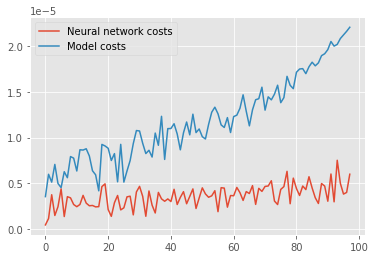

In [ ]:
plt.plot(cost_realized_SU[50,1:99], label = 'Neural network costs')
plt.plot(cost_gamma2[50,1:99],label = 'Model costs')
plt.legend()

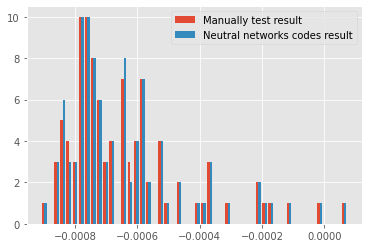

In [ ]:
plt.hist([test_PnL_manually,PnL_SU_95_cost_small], label = [ 'Manually test result','Neutral networks codes result'], bins = 50)
plt.legend()

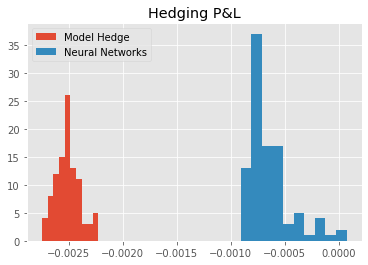

In [ ]:
plt.hist(PnL_gamma_costs_2, label = 'Model Hedge')
plt.hist(PnL_SU_95_cost_small, label = 'Neural Networks')
plt.title('Hedging P&L')
plt.legend()

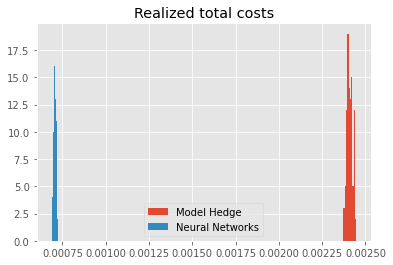

In [ ]:
modelcost = np.sum(cost_gamma2, axis = -1)
NNcost = np.sum(cost_realized_SU, axis = -1)
np.shape(cost_realized_SU)
np.shape(cost_gamma2)
plt.hist(modelcost, label = 'Model Hedge')
plt.hist(total_cost_manually, label = 'Neural Networks')
plt.title('Realized total costs')
plt.legend()

# Codes for  discussion about indifference price

In [ ]:
# Generate the training and testing data set
rtrain_Q,times = simulateVasicek(a, b, sigma , T, r0, ntrain, nSteps)
r_0 = [r0]
r_0 = np.repeat(r_0,ntrain,axis =0)
r_train_Q = np.concatenate((np.reshape(r_0,(ntrain,1)),rtrain_Q),axis = 1)
print(np.shape(r_train_Q))
rtest_Q,times = simulateVasicek(a, b, sigma , T, r0, ntest, nSteps)
r_0 = [r0]
r_0 = np.repeat(r_0,ntest,axis =0)
r_test_Q = np.concatenate((np.reshape(r_0,(ntest,1)),rtest_Q),axis = 1)

print(np.shape(r_test_Q))
price_S_Q = np.zeros((ntrain,nSteps+1))
price_U_Q = np.zeros((ntrain,nSteps+1))
prc_S_test_Q = np.zeros((ntest,nSteps+1))
prc_U_test_Q = np.zeros((ntest,nSteps+1))
moneymarket_Q = np.zeros((ntrain,nSteps+1))
moneymarket_test_Q = np.zeros((ntest,nSteps+1))
for i in range(nSteps+1):
    price_U_Q[:,i],_ , _   = affinebondprcing(a,b, sigma, times[i] , U , r_train_Q[:,i])
    price_S_Q[:,i],_ , _   = affinebondprcing(a,b, sigma, times[i] , S , r_train_Q[:,i])
    prc_U_test_Q[:,i],_ , _ = affinebondprcing(a,b, sigma, times[i] , U , r_test_Q[:,i])
    prc_S_test_Q[:,i],_ , _ = affinebondprcing(a,b, sigma, times[i] , S , r_test_Q[:,i])
    moneymarket_Q[:,i] = ShortMaturityPricing(r_train_Q[:,i])
    moneymarket_test_Q[:,i] = ShortMaturityPricing(r_test_Q[:,i])
FeedSUtrain_Q = []
for i in range(nSteps+1):
  S_helper = np.reshape(price_S_Q[:,i],(ntrain,1))
  U_helper = np.reshape(price_U_Q[:,i],(ntrain,1))
  FeedSUtrain_Q.append(np.concatenate((S_helper,U_helper),axis =1))
for i in range(nSteps+1):
  moneymarket_helper = np.reshape(moneymarket_Q[:,i],(ntrain,1)) 
  FeedSUtrain_Q.append(moneymarket_helper)

print(np.shape(FeedSUtrain_Q[1]))

FeedSUtest_Q = []
for i in range(nSteps+1):
  S_helper = np.reshape(prc_S_test_Q[:,i],(ntest,1))
  U_helper = np.reshape(prc_U_test_Q[:,i],(ntest,1))
  FeedSUtest_Q.append(np.concatenate((S_helper, U_helper),axis =1))
for i in range(nSteps+1):
  moneymarket_helper = np.reshape(moneymarket_test_Q[:,i],(ntest,1)) 
  FeedSUtest_Q.append(moneymarket_helper)
 
print(np.shape(FeedSUtest_Q[1]))

(500000, 101)
(300000, 101)
(500000, 2)
(300000, 2)


In [ ]:
moneymarket_discount_test_Q = accrue_moneymarket_discount(moneymarket_test_Q)
moneymarket_discount_train_Q= accrue_moneymarket_discount(moneymarket_Q)

In [ ]:
SU_entropic_P =  FeedSU_bond_FNN(trans_costs= True, charge= 0,selling = False, epsilon= eps[4])
SU_entropic_P.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.005),loss = entropic_1)
SU_entropic_P.fit(FeedSUtrain , ytrain, batch_size=250, epochs = 20, callbacks = callback2, validation_split = 0.3)
SU_entropic_Q =  FeedSU_bond_FNN(trans_costs= True, charge= 0,selling = False, epsilon= eps[4])
SU_entropic_Q.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.005),loss = entropic_1)
SU_entropic_Q.fit(FeedSUtrain_Q, ytrain, batch_size=250, epochs = 20, callbacks = callback2, validation_split = 0.3)

Epoch 1/20
1400/1400 [==============================] - 41s 30ms/step - loss: 0.9720 - val_loss: 0.9634
Epoch 2/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9631 - val_loss: 0.9632
Epoch 3/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9631 - val_loss: 0.9631
Epoch 4/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9631 - val_loss: 0.9631
Epoch 5/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9631 - val_loss: 0.9631
Epoch 6/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9631 - val_loss: 0.9631
Epoch 7/20
1400/1400 [==============================] - 39s 28ms/step - loss: 0.9631 - val_loss: 0.9631
Epoch 8/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9631 - val_loss: 0.9631
Epoch 9/20
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9631 - val_loss: 0.9631
Epoch 10/20
1400/1400 [==============================] - 35s 25m

In [ ]:
tf.keras.backend.set_learning_phase(0)
PnL_entropic_P = np.reshape(SU_entropic_P.predict(FeedSUtest),(ntest,))
PnL_entropic_Q = np.reshape(SU_entropic_Q.predict(FeedSUtest_Q),(ntest,))


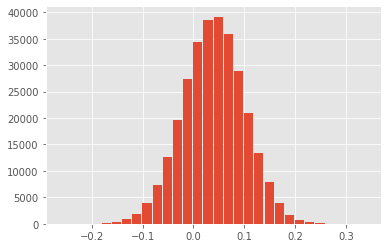

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

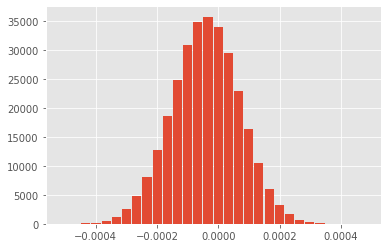

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-0.96306926 -1.0000416


In [ ]:
trading_P = plt.figure()
plt.hist(PnL_entropic_P, bins = 30, rwidth= 0.9)
plt.show()
trading_P.savefig('utility_P.png')
files.download('utility_P.png')
trading_Q = plt.figure()
plt.hist(PnL_entropic_Q ,bins = 30,rwidth= 0.9)
plt.show()
trading_Q.savefig('utility_Q.png')
files.download('utility_Q.png')
utility_P = exponential_utility(PnL_entropic_P ,1)
utility_Q = exponential_utility(PnL_entropic_Q ,1)
print(utility_P,utility_Q )

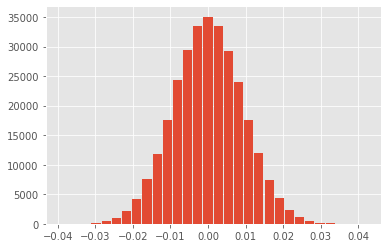

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trading_Q = plt.figure()
plt.hist(PnL_entropic_Q,bins = 30,rwidth= 0.9)
plt.show()
utility_Q.savefig('utility_Q.png')
#files.download('utility_Q.png')

In [ ]:
utility_P = exponential_utility(PnL_entropic_P ,1)
utility_Q = exponential_utility(PnL_entropic_Q ,1)
print(utility_P,utility_Q )